In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [2]:
from sklearn.externals import joblib

docdict = joblib.load('docdict.pkl')

In [3]:
print docdict['Ludmila Davidov, MD']
print
print docdict['Igor Gavrilovic, MD']

Dr. Ludmila Davidov, MD is one of the country's most highly ranked doctors. Her specialties include psychiatry and she currently treats patients in Flushing, New York, Rego park, New York, and Whitestone, New York.  Dr. Davidov completed medical school at Tajik State Medical University Named After Abuali Ibn Sino and is licensed to see patients in New York.  Based on an in-depth analysis of Dr. Davidov's credentials, experience and network, she has been found to be among the 20% of doctors nationwide.  Dr. Davidov has been found to hold one or more active medical licenses, and successfully passed a malpractice history screening.

I am a neurologist with specialty training in neuro-oncology who sees patients at Memorial Sloan-Kettering facilities in both New York City and Basking Ridge, New Jersey. I treat patients with primary brain tumors and patients with neurological complications of systemic cancer. As a neuro-oncologist, I provide continuity of care for those patients with primary

In [4]:
len(docdict)

1899

In [ ]:
2691-2051

### stopwords, stemming and tokenizing

In [4]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [6]:
print len(stopwords)

127


In [8]:
print stopwords

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

In [5]:
stopwords = stopwords[29:]

In [6]:
stopwords.extend(['psychiatry', 'currently', 'medicine', 'new york', 'licenses', 'active', 'medical', \
                  'having', 'successfully', 'passed', 'malpractice', 'hold', 'screening', 'history', \
                  'rated', '20', 'doctors', 'nationwide', 'based', 'depth', 'analysis', 'background', \
                  'check', 'active', 'automated', 'elements', 'including', 'license', 'patients', 'dr.' ])

In [7]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [8]:
# here he defines a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [9]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in docdict.values():
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [10]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 135761 items in vocab_frame


In [11]:
vocab_frame.head()

,words
dr.,dr.
ludmila,ludmila
davidov,davidov
md,md
is,is


### Tf-idf and document similarity

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                   stop_words=stopwords, use_idf=True,
                                   tokenizer=tokenize_only, ngram_range=(2,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(docdict.values()) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 5.98 s, sys: 85.6 ms, total: 6.07 s
Wall time: 6.73 s
(1899, 53882)


In [13]:
terms = tfidf_vectorizer.get_feature_names()

In [14]:
terms[0:10]

[u"'s adult",
 u"'s adult long-term",
 u"'s advisory",
 u"'s advisory committee",
 u"'s affairs",
 u"'s affairs center",
 u"'s areas",
 u"'s areas interest",
 u"'s best",
 u"'s best cross"]

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [26]:
print dist.shape

(1899, 1899)


### K-means clustering

In [85]:
print(tfidf_matrix.shape)

(1899, 53882)


In [86]:
from sklearn.cluster import KMeans

n = 3
km = KMeans(n_clusters=n)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 1.96 s, sys: 203 ms, total: 2.16 s
Wall time: 2.37 s


In [87]:
joblib.dump(km,  'doc_cluster_custom_stopwords_2.pkl')
clusters = km.labels_.tolist()

### hacky attempt at reading level

In [88]:
sentlen = []
wordlen = []
fkgl  = []
counts = []

In [89]:
from __future__ import division
sentlen = [nltk.sent_tokenize(d) for d in docdict.values()]
wordlen = [[nltk.word_tokenize(t) for t in bio] for bio in sentlen]
for dr in wordlen:
    sentence_cnt = len(dr)
    word_cnt = 0
    letter_cnt = 0
    for sentence in dr:
        word_cnt += len(sentence)
        for word in sentence:
            letter_cnt += len(word)
    counts.append((sentence_cnt, word_cnt, letter_cnt))
    
print(counts[0])

def catch(func, handle=lambda e : e, *args, **kwargs):
    try:
        return func(*args, **kwargs)
    except ZeroDivisionError:
        return np.nan

fkgl = [catch(lambda: 0.39 * (dr[1]/dr[0]) + 11.8 * (dr[2]/dr[1])/2.83 - 15.59) \
        for dr in counts]

(5, 119, 532)


In [32]:
fkgl.count(np.nan)

0

In [33]:
len(fkgl)

1899

In [34]:
fkgl[0]

12.332615256703388

In [91]:
max(fkgl)

47.35116607773851

In [90]:
min(fkgl)

5.826548881036516

### looking at the clusters

In [37]:
clusters[0]

2

In [38]:
print len(docdict.keys())
print len(docdict.values())
print len(fkgl)
print len(clusters)

1899
1899
1899
1899


In [92]:
docs = { 'name': docdict.keys(), 'bio': docdict.values(), 'flesch_kincaid': fkgl, 'cluster': clusters }

In [93]:
len(vocab_frame)

135761

In [94]:
df = pd.DataFrame(docs, index = [clusters] , columns = ['name', 'flesch_kincaid', 'bio', 'cluster'])

In [95]:
df['cluster'].value_counts()

0    1517
2     207
1     175
Name: cluster, dtype: int64

In [96]:
grouped = df['flesch_kincaid'].groupby(df['cluster']) #groupby cluster for aggregation purposes

grouped.mean() #average flesch_kincaid per cluster

cluster
0    12.790803
1    23.717654
2    11.055232
Name: flesch_kincaid, dtype: float64

In [97]:
grouped.median()

cluster
0    12.385010
1    23.112517
2    10.883980
Name: flesch_kincaid, dtype: float64

In [98]:
num_clusters = len(pd.unique(df['cluster']))

In [99]:
terms[7048].split(" ")

[u'cancer', u'considering']

In [51]:
#vocab_frame.ix[terms[7048].split(" ")].values.tolist()[0][0]

In [100]:
terms[33679].encode('utf-8', 'ignore')

'pennsylvania new'

In [101]:
terms[33679].split(" ")

[u'pennsylvania', u'new']

In [53]:
#vocab_frame.ix[terms[33679].split(" ")]

In [129]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        try:
            print(' %s' % terms[ind].encode('utf-8', 'ignore'), end=',')
            print()
        except AttributeError as e:
            print("AttributeError")
    print() #add whitespace
    print() #add whitespace
    
#     print("Cluster %d titles:" % i, end='')
#     for title in df.ix[i]['name'].values.tolist():
#         print(' %s,' % title, end='')
#     print() #add whitespace
#     print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: york new,
 new york new,
 york new york,
 new york addition,
 york addition,
 md specialist,


Cluster 1 words: hospice palliative neurology,
 neurology forensic neurology,
 neuropsychiatry neurology diagnostic,
 neuropsychiatry neurology,
 diagnostic neuroimaging neurology,
 neuroimaging neurology,


Cluster 2 words: united states,
 md one,
 one country,
 one country 's,
 country 's,
 top united states,






In [104]:
cluster0 = df.ix[0]
cluster1 = df.ix[1]
cluster2 = df.ix[2]

In [105]:
cluster0.head()

,name,flesch_kincaid,bio,cluster
0,"Hersha Diaz, PSYD",11.019929,"Dr. Hersha Diaz, PSYD specializes in psycholog...",0
0,"Paula Marcus, MD",10.896992,"Dr. Paula Marcus, MD specializes in psychiatry...",0
0,"Igor Gavrilovic, MD",19.305265,I am a neurologist with specialty training in ...,0
0,"Jason Kim, MD",9.237196,"Dr. Jason Kim, MD--specialist in psychiatry--c...",0
0,"Morgana Martinez, MD",12.448603,"Dr. Morgana Martinez, MD practices medicine at...",0


In [106]:
print(df.columns)

Index([u'name', u'flesch_kincaid', u'bio', u'cluster'], dtype='object')


In [107]:
type(cluster0)

pandas.core.frame.DataFrame

In [108]:
joblib.dump(cluster0, 'doc_cluster0_stop.pkl')
joblib.dump(cluster1, 'doc_cluster1_stop.pkl')
joblib.dump(cluster2, 'doc_cluster2_stop.pkl')

['doc_cluster2_stop.pkl',
 'doc_cluster2_stop.pkl_01.npy',
 'doc_cluster2_stop.pkl_02.npy',
 'doc_cluster2_stop.pkl_03.npy',
 'doc_cluster2_stop.pkl_04.npy',
 'doc_cluster2_stop.pkl_05.npy']

In [103]:
print(df[df['name']=='Ludmila Davidov, MD'])
print(docdict['Ludmila Davidov, MD'])
print()
print(df[df['name']=='Igor Gavrilovic, MD'])
print(docdict['Igor Gavrilovic, MD'])

                  name  flesch_kincaid  \
2  Ludmila Davidov, MD       12.332615   

                                                 bio  cluster  
2  Dr. Ludmila Davidov, MD is one of the country'...        2  
Dr. Ludmila Davidov, MD is one of the country's most highly ranked doctors. Her specialties include psychiatry and she currently treats patients in Flushing, New York, Rego park, New York, and Whitestone, New York.  Dr. Davidov completed medical school at Tajik State Medical University Named After Abuali Ibn Sino and is licensed to see patients in New York.  Based on an in-depth analysis of Dr. Davidov's credentials, experience and network, she has been found to be among the 20% of doctors nationwide.  Dr. Davidov has been found to hold one or more active medical licenses, and successfully passed a malpractice history screening.

                  name  flesch_kincaid  \
0  Igor Gavrilovic, MD       19.305265   

                                                 bio  cluster  


In [ ]:
print(docdict['Sharon Lee, MD'])
print()
print(docdict['Carol Bernstein, MD'])

In [ ]:
vocab_frame.ix[terms[2].split(' ')].values.tolist()[360][0]

In [109]:
import lda
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [115]:
ludmila.split(".")

[u'Dr',
 u" Ludmila Davidov, MD is one of the country's most highly ranked doctors",
 u' Her specialties include psychiatry and she currently treats patients in Flushing, New York, Rego park, New York, and Whitestone, New York',
 u'  Dr',
 u' Davidov completed medical school at Tajik State Medical University Named After Abuali Ibn Sino and is licensed to see patients in New York',
 u'  Based on an in-depth analysis of Dr',
 u" Davidov's credentials, experience and network, she has been found to be among the 20% of doctors nationwide",
 u'  Dr',
 u' Davidov has been found to hold one or more active medical licenses, and successfully passed a malpractice history screening',
 u'']

In [114]:
igor

u'I am a neurologist with specialty training in neuro-oncology who sees patients at Memorial Sloan-Kettering facilities in both New York City and Basking Ridge, New Jersey. I treat patients with primary brain tumors and patients with neurological complications of systemic cancer. As a neuro-oncologist, I provide continuity of care for those patients with primary CNS malignancies and coordinate the multidisciplinary management team consisting of neurosurgeons and radiation oncologists. I actively participate in clinical trials at Memorial Sloan-Kettering, including those through the North American Brain Tumor Consortium, in order to evaluate novel chemotherapy, biological, and molecular treatments for patients with malignant brain tumors.'

In [121]:
ludmila = docdict['Ludmila Davidov, MD'].split(".")
vectorizer=CountVectorizer(stop_words='english')
doc_vecs_one=vectorizer.fit_transform(ludmila)
vocab_one=vectorizer.get_feature_names()

# igor
igor = docdict['Igor Gavrilovic, MD'].split(".")
vectorizer=CountVectorizer(stop_words='english')
doc_vecs_two=vectorizer.fit_transform(igor)
vocab_two=vectorizer.get_feature_names()


In [122]:
vecs=[doc_vecs_one,doc_vecs_two]
vocab=[vocab_one,vocab_two]

In [124]:
for v in range(len(vecs)):

    model = lda.LDA(n_topics=2, n_iter=5,random_state=0)
    model.fit(vecs[v])
    topic_word = model.topic_word_  # model.components_ also works
    n_top_words = 5
    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vocab[v])[np.argsort(topic_dist)][:-(n_top_words+1):-1]
        print('Topic {}: {}'.format(i, ' '.join(topic_words)))
    print('\n')
    print('\n')

Topic 0: york davidov dr patients doctors
Topic 1: new medical malpractice history named




Topic 0: neuro sloan basking facilities north
Topic 1: patients brain kettering primary memorial






### Attempt at PCA

In [125]:
from sklearn.decomposition import PCA

In [181]:
pca = PCA(n_components=3)

In [182]:
pos = pca.fit_transform(dist) # shape (n_components, n_samples)

In [183]:
xs, ys, zs = pos[:, 0], pos[:, 1], pos[:, 2]

In [130]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

#set up cluster names using a dict
cluster_names = {0: 'New York', 
                 1: 'Neurology, Neuropsychiatry', 
                 2: 'Top United States',}

In [131]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

In [252]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 205);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [142]:
len(df.bio)

1899

In [144]:
from matplotlib import pyplot as plt

In [152]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
plotdf = pd.DataFrame(dict(x=xs, y=ys, z=zs, label=clusters, title=df.bio)) 

#group by cluster
groups = plotdf.groupby('label')

groups.head()

,label,title,x,y,z
2,2,"Dr. Ludmila Davidov, MD is one of the country'...",-0.427348,0.492913,-0.323248
2,2,"Specializing in psychiatry, Dr. Faiq Hameedi, ...",-0.366341,0.267118,-0.628001
0,0,"Dr. Hersha Diaz, PSYD specializes in psycholog...",-0.322836,0.099978,0.127695
0,0,"Dr. Paula Marcus, MD specializes in psychiatry...",-0.305666,-0.034699,0.063378
0,0,I am a neurologist with specialty training in ...,-0.440517,0.555092,0.342631
0,0,"Dr. Jason Kim, MD--specialist in psychiatry--c...",-0.246998,-0.191494,0.064789
0,0,"Dr. Morgana Martinez, MD practices medicine at...",-0.256805,-0.065992,0.133463
1,1,"Dr. Damian Kim, MD--specialist in addiction ps...",2.160606,0.023647,-0.051552
2,2,"Dr. Zana Dobroshi, MD is one of the country's ...",-0.361609,0.326649,-0.602375
2,2,"Dr. Daniel Sanchez, MD is one of the country's...",-0.377393,0.561323,-0.592330


In [153]:
from mpl_toolkits.mplot3d import Axes3D

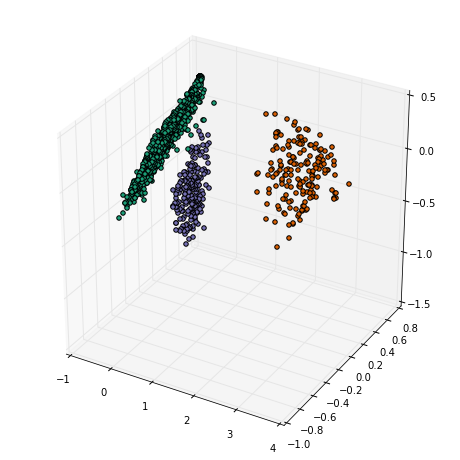

In [263]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for x, y, z, cluster in zip(xs, ys, zs, clusters):
    ax.scatter(x, y, z, c=cluster_colors[cluster], marker='o')


plt.show()

In [261]:
xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()

In [274]:
max(ys)

0.64603460493641363

In [278]:
max(xs)

3.6795607598941933

AttributeError: 'module' object has no attribute 'zticks'

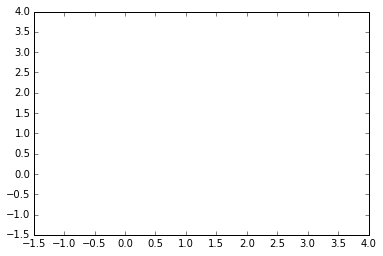

In [280]:
plt.xticks(np.arange(-1.5, 4.5, 0.5))
plt.yticks(np.arange(-1.5, 4.5, 0.5))
plt.zticks(np.arange(-1.5, 4.5, 0.5))

In [275]:
ax.xaxis.set_ticks(np.arange(-2, 5, 1))
ax.yaxis.set_ticks(np.arange(-2, 5, 1))
ax.zaxis.set_ticks(np.arange(-2, 5, 1))

In [177]:
pca2d = PCA(n_components=2)
pos2d = pca2d.fit_transform(dist) # shape (n_components, n_samples)
xs2d, ys2d = pos2d[:, 0], pos2d[:, 1]

In [253]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
plotdf = pd.DataFrame(dict(x=xs2d, y=ys2d, label=clusters, title=df.bio)) 

#group by cluster
groups = plotdf.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)